# 第10章 数据聚合与分组运算

## 10.1 GroupBy机制 

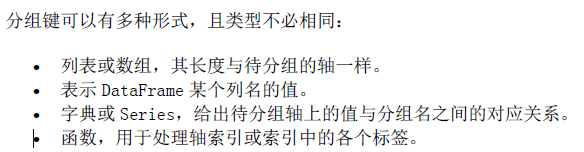

In [1]:
import pandas as pd
import numpy as np
import os

In [2]:
df = pd.DataFrame({'key1' : ['a', 'a', 'b', 'b', 'a'],
                   'key2' : ['one', 'two', 'one', 'two', 'one'],
                   'data1' : np.random.randn(5),
                   'data2' : np.random.randn(5)})
df

,key1,key2,data1,data2
0,a,one,-2.011984,-0.296915
1,a,two,0.179238,1.278914
2,b,one,-0.966794,1.569476
3,b,two,1.477992,0.202784
4,a,one,-0.268047,-1.011819


In [5]:
grouped = df['data1'].groupby(df['key1'])
grouped.mean()

key1
a   -0.700264
b    0.255599
Name: data1, dtype: float64

In [7]:
means = df['data1'].groupby([df['key1'], df['key2']]).mean()
print(means)
means.unstack()

key1  key2
a     one    -1.140015
      two     0.179238
b     one    -0.966794
      two     1.477992
Name: data1, dtype: float64


key2,one,two
key1,,
a,-1.140015,0.179238
b,-0.966794,1.477992


In [8]:
states = np.array(['Ohio', 'California', 'California', 'Ohio', 'Ohio'])
years = np.array([2005, 2005, 2006, 2005, 2006])
df['data1'].groupby([states, years]).mean()

California  2005    0.179238
            2006   -0.966794
Ohio        2005   -0.266996
            2006   -0.268047
Name: data1, dtype: float64

In [12]:
#只有dataframe使用groupby的时候才能传入列名做分组键(df['data1'].groupby('key1')将会报错)
#默认情况下，会将所有的数据列聚合
print(df.groupby('key1').mean())
df.groupby(['key1', 'key2']).mean()

         data1    data2
key1                   
a    -0.700264 -0.00994
b     0.255599  0.88613


data1     data2
key1 key2                    
a    one  -1.140015 -0.654367
     two   0.179238  1.278914
b    one  -0.966794  1.569476
     two   1.477992  0.202784

In [13]:
df.groupby(['key1', 'key2']).size() #输出含有分组大小的size()

key1  key2
a     one     2
      two     1
b     one     1
      two     1
dtype: int64

### 对分组进行迭代 

In [22]:
for name, group in df.groupby('key1'):
    print(name)
    print('-------------')
    print(group)
    print('=============')
#多重键的情况，元组的第一个元素将会是由键值组成的元组
for (k1, k2), group in df.groupby(['key1', 'key2']):
    print((k1, k2))
    print(group)

a
-------------
  key1 key2     data1     data2
0    a  one -2.011984 -0.296915
1    a  two  0.179238  1.278914
4    a  one -0.268047 -1.011819
b
-------------
  key1 key2     data1     data2
2    b  one -0.966794  1.569476
3    b  two  1.477992  0.202784
('a', 'one')
  key1 key2     data1     data2
0    a  one -2.011984 -0.296915
4    a  one -0.268047 -1.011819
('a', 'two')
  key1 key2     data1     data2
1    a  two  0.179238  1.278914
('b', 'one')
  key1 key2     data1     data2
2    b  one -0.966794  1.569476
('b', 'two')
  key1 key2     data1     data2
3    b  two  1.477992  0.202784


In [27]:
#key为key1中的值(a, b)， values为dataframe类型的数据
pieces = dict(list(df.groupby('key1')))
pieces['b']

pandas.core.frame.DataFrame

In [28]:
print(df.dtypes)
grouped = df.groupby(df.dtypes, axis=1)
for dtype, group in grouped:
    print(dtype)
    print(group)

key1      object
key2      object
data1    float64
data2    float64
dtype: object
float64
      data1     data2
0 -2.011984 -0.296915
1  0.179238  1.278914
2 -0.966794  1.569476
3  1.477992  0.202784
4 -0.268047 -1.011819
object
  key1 key2
0    a  one
1    a  two
2    b  one
3    b  two
4    a  one


### 选取一列或列的子集

In [32]:
df.groupby('key1')['data1'] #加入聚合操作结果为series形式
df.groupby('key1')[['data2']] #加入聚合操作结果为dataframe形式
#equal to
df['data1'].groupby(df['key1'])
df[['data2']].groupby(df['key1']) 

In [36]:
df.groupby(['key1', 'key2'])[['data2']].mean() #dataframe

data2
key1 key2          
a    one  -0.654367
     two   1.278914
b    one   1.569476
     two   0.202784

In [37]:
s_grouped = df.groupby(['key1', 'key2'])['data2']
s_grouped
s_grouped.mean() #series

key1  key2
a     one    -0.654367
      two     1.278914
b     one     1.569476
      two     0.202784
Name: data2, dtype: float64

### 通过字典或series进行分组 

In [38]:
people = pd.DataFrame(np.random.randn(5, 5),
                      columns=['a', 'b', 'c', 'd', 'e'],
                      index=['Joe', 'Steve', 'Wes', 'Jim', 'Travis'])
people.iloc[2:3, [1, 2]] = np.nan # Add a few NA values
people

,a,b,c,d,e
Joe,-0.089006,-0.776244,-0.257851,-1.229653,0.787897
Steve,-1.489040,-1.924619,1.401504,-0.083855,0.298877
Wes,0.972402,NaN,NaN,0.617974,0.319555
Jim,0.629316,-1.473954,1.174134,0.317593,1.076875
Travis,0.857366,-0.572646,-1.665276,0.462301,0.535018


In [39]:
mapping = {'a': 'red', 'b': 'red', 'c': 'blue',
           'd': 'blue', 'e': 'red', 'f' : 'orange'} #

In [41]:
by_column = people.groupby(mapping, axis=1) #传入一个字典，people中没有f这一列，未使用的分组键不影响
by_column.sum()

,blue,red
Joe,-1.487504,-0.077352
Steve,1.317650,-3.114782
Wes,0.617974,1.291957
Jim,1.491727,0.232237
Travis,-1.202976,0.819738


In [44]:
map_series = pd.Series(mapping) #seriees也有和字典一样的功能，能传入groupby，当成时一个固定大小的映射
print(map_series)
print(map_series['a'])
people.groupby(map_series, axis=1).count()

a       red
b       red
c      blue
d      blue
e       red
f    orange
dtype: object
red


,blue,red
Joe,2,3
Steve,2,3
Wes,1,2
Jim,2,3
Travis,2,3


### 通过函数进行分组 

In [48]:
#任何被当作分组键的函数都会再各个 索引值 上被调用一次，返回值被用作分组名称
people.groupby(len).sum() #根据索引(name)的字符长度作为分组键

,a,b,c,d,e
3,1.512713,-2.250198,0.916283,-0.294086,2.184327
5,-1.489040,-1.924619,1.401504,-0.083855,0.298877
6,0.857366,-0.572646,-1.665276,0.462301,0.535018


In [49]:
#函数也可以和列表、字典、series混合使用 (本质上最后传入的都是一组数组)
key_list = ['one', 'one', 'one', 'two', 'two']
people.groupby([len, key_list]).min()

a         b         c         d         e
3 one -0.089006 -0.776244 -0.257851 -1.229653  0.319555
  two  0.629316 -1.473954  1.174134  0.317593  1.076875
5 one -1.489040 -1.924619  1.401504 -0.083855  0.298877
6 two  0.857366 -0.572646 -1.665276  0.462301  0.535018

### 根据索引级别分组 

In [53]:
columns = pd.MultiIndex.from_arrays([['US', 'US', 'US', 'JP', 'JP'],
                                   [1, 3, 5, 1, 3]],
                                   names=['cty', 'tenor'])
hier_df = pd.DataFrame(np.random.randn(4, 5), columns=columns)
hier_df

cty          US                            JP          
tenor         1         3         5         1         3
0     -0.160036 -0.272240 -0.682414 -0.404180  0.457395
1     -0.577822  0.861698  0.064188  0.527155 -0.072005
2      1.144768  1.981519 -1.061260 -0.632639  1.454309
3      0.730437 -0.008385 -1.913922  1.248768  0.297787

In [56]:
hier_df.groupby(level='cty', axis=1).count() #level传递级别序号/名字

cty,JP,US
0,2,3
1,2,3
2,2,3
3,2,3


## 10.2 数据聚合 

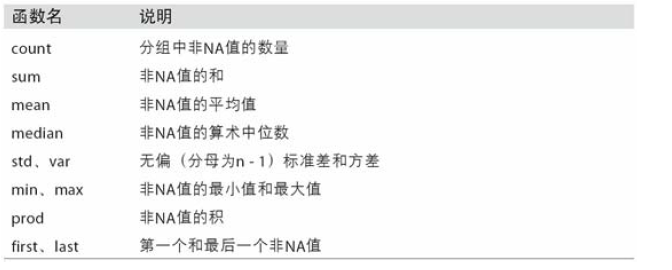

In [58]:
print(df)
grouped = df.groupby('key1')
grouped['data1'].quantile(0.9)

  key1 key2     data1     data2
0    a  one -2.011984 -0.296915
1    a  two  0.179238  1.278914
2    b  one -0.966794  1.569476
3    b  two  1.477992  0.202784
4    a  one -0.268047 -1.011819


0.9,data1,data2
key1,,
a,0.089781,0.963748
b,1.233514,1.432807


In [59]:
#传入aggregate 或 agg 调用自己的聚合函数
def peak_to_peak(arr):
    return arr.max() - arr.min()
grouped.agg(peak_to_peak)

,data1,data2
key1,,
a,2.191222,2.290733
b,2.444787,1.366693


In [61]:
#有一些series的方法函数也可以使用，即使严格来说并不是聚合运算
grouped.describe()

data1                                                              \
     count      mean       std       min       25%       50%       75%   
key1                                                                     
a      3.0 -0.700264  1.157788 -2.011984 -1.140015 -0.268047 -0.044404   
b      2.0  0.255599  1.728725 -0.966794 -0.355598  0.255599  0.866796   

               data2                                                   \
           max count     mean       std       min       25%       50%   
key1                                                                    
a     0.179238   3.0 -0.00994  1.172020 -1.011819 -0.654367 -0.296915   
b     1.477992   2.0  0.88613  0.966398  0.202784  0.544457  0.886130   

                          
           75%       max  
key1                      
a     0.490999  1.278914  
b     1.227803  1.569476

### 面向列的多函数应用 

In [62]:
os.chdir('E:\personal_file\study_file\python数据分析学习\pydata-book-2nd-edition')

In [63]:
tips = pd.read_csv('examples/tips.csv')
print(tips.head())
tips['tip_pct'] = tips['tip'] / tips['total_bill']
tips[:6]

   total_bill   tip smoker  day    time  size
0       16.99  1.01     No  Sun  Dinner     2
1       10.34  1.66     No  Sun  Dinner     3
2       21.01  3.50     No  Sun  Dinner     3
3       23.68  3.31     No  Sun  Dinner     2
4       24.59  3.61     No  Sun  Dinner     4


,total_bill,tip,smoker,day,time,size,tip_pct
0,16.99,1.01,No,Sun,Dinner,2,0.059447
1,10.34,1.66,No,Sun,Dinner,3,0.160542
2,21.01,3.50,No,Sun,Dinner,3,0.166587
3,23.68,3.31,No,Sun,Dinner,2,0.139780
4,24.59,3.61,No,Sun,Dinner,4,0.146808
5,25.29,4.71,No,Sun,Dinner,4,0.186240


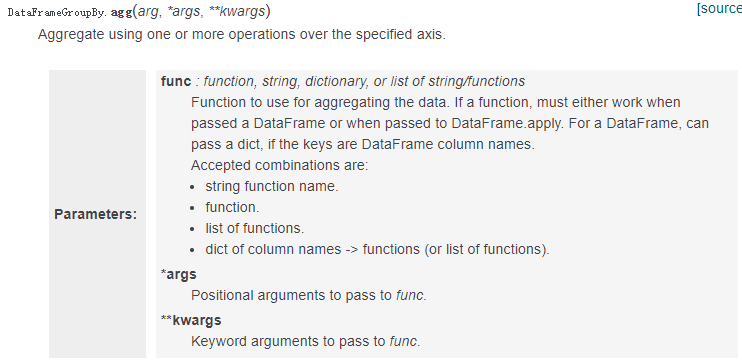

In [67]:
#对不同了列使用不同聚合函数，或一次用多个函数
grouped = tips.groupby(['day', 'smoker'])
grouped_pct = grouped['tip_pct']
grouped_pct.agg('mean') #注意这里的mean是字符串形式，可以被agg识别，也可以传入np.mean
#具体可以传入哪些string function name？

day   smoker
Fri   No        0.151650
      Yes       0.174783
Sat   No        0.158048
      Yes       0.147906
Sun   No        0.160113
      Yes       0.187250
Thur  No        0.160298
      Yes       0.163863
Name: tip_pct, dtype: float64

In [69]:
grouped_pct.agg(['mean', 'std', peak_to_peak]) #传入一组函数则得到的dataframe以函数命名列名

mean       std  peak_to_peak
day  smoker                                  
Fri  No      0.151650  0.028123      0.067349
     Yes     0.174783  0.051293      0.159925
Sat  No      0.158048  0.039767      0.235193
     Yes     0.147906  0.061375      0.290095
Sun  No      0.160113  0.042347      0.193226
     Yes     0.187250  0.154134      0.644685
Thur No      0.160298  0.038774      0.193350
     Yes     0.163863  0.039389      0.151240

In [71]:
#想要用自己的定义的name做列名则可以传入(name, function)元组组成的列表
grouped_pct.agg([('foo', 'mean'), ('bar', np.std)])

foo       bar
day  smoker                    
Fri  No      0.151650  0.028123
     Yes     0.174783  0.051293
Sat  No      0.158048  0.039767
     Yes     0.147906  0.061375
Sun  No      0.160113  0.042347
     Yes     0.187250  0.154134
Thur No      0.160298  0.038774
     Yes     0.163863  0.039389

In [74]:
functions = ['count', 'mean', 'max']
result = grouped['tip_pct', 'total_bill'].agg(functions)
print(result['tip_pct'])
result

             count      mean       max
day  smoker                           
Fri  No          4  0.151650  0.187735
     Yes        15  0.174783  0.263480
Sat  No         45  0.158048  0.291990
     Yes        42  0.147906  0.325733
Sun  No         57  0.160113  0.252672
     Yes        19  0.187250  0.710345
Thur No         45  0.160298  0.266312
     Yes        17  0.163863  0.241255


tip_pct                     total_bill                  
              count      mean       max      count       mean    max
day  smoker                                                         
Fri  No           4  0.151650  0.187735          4  18.420000  22.75
     Yes         15  0.174783  0.263480         15  16.813333  40.17
Sat  No          45  0.158048  0.291990         45  19.661778  48.33
     Yes         42  0.147906  0.325733         42  21.276667  50.81
Sun  No          57  0.160113  0.252672         57  20.506667  48.17
     Yes         19  0.187250  0.710345         19  24.120000  45.35
Thur No          45  0.160298  0.266312         45  17.113111  41.19
     Yes         17  0.163863  0.241255         17  19.190588  43.11

In [83]:
ftuples = [('Durchschnitt', 'mean'), ('Abweichung', np.var)]
grouped['tip_pct', 'total_bill'].agg(ftuples)

total_bill                      tip                    size  \
            Durchschnitt  Abweichung Durchschnitt Abweichung Durchschnitt   
day  smoker                                                                 
Fri  No        18.420000   25.596333     2.812500   0.807292     2.250000   
     Yes       16.813333   82.562438     2.714000   1.161369     2.066667   
Sat  No        19.661778   79.908965     3.102889   2.696453     2.555556   
     Yes       21.276667  101.387535     2.875476   2.658791     2.476190   
Sun  No        20.506667   66.099980     3.167895   1.500099     2.929825   
     Yes       24.120000  109.046044     3.516842   1.590501     2.578947   
Thur No        17.113111   59.625081     2.673778   1.645997     2.488889   
     Yes       19.190588   69.808518     3.030000   1.239863     2.352941   

                            tip_pct             
            Abweichung Durchschnitt Abweichung  
day  smoker                                     
Fri  No       0.250000     0.151650   0.000791  
     Yes      0.352381     0.174783   0.002631  
Sat  No       0.616162     0.158048   0.001581  
     Yes      0.743322     0.147906   0.003767  
Sun  No       1.066416     0.160113   0.001793  
     Yes      0.812865     0.187250   0.023757  
Thur No       1.391919     0.160298   0.001503  
     Yes      0.492647     0.163863   0.001551

In [90]:
#对不同的列应用不同的聚合函数，需要传入从列名映射到函数的字典
grouped.agg({'tip':np.max, 'size':'sum'})

tip  size
day  smoker             
Fri  No       3.50     9
     Yes      4.73    31
Sat  No       9.00   115
     Yes     10.00   104
Sun  No       6.00   167
     Yes      6.50    49
Thur No       6.70   112
     Yes      5.00    40

In [78]:
#只有将多个函数应用到至少一列时，dataframe才有层次化的列
grouped.agg({'tip_pct' : ['min', 'max', 'mean', 'std'],
             'size' : 'sum'})

tip_pct                               size
                  min       max      mean       std  sum
day  smoker                                             
Fri  No      0.120385  0.187735  0.151650  0.028123    9
     Yes     0.103555  0.263480  0.174783  0.051293   31
Sat  No      0.056797  0.291990  0.158048  0.039767  115
     Yes     0.035638  0.325733  0.147906  0.061375  104
Sun  No      0.059447  0.252672  0.160113  0.042347  167
     Yes     0.065660  0.710345  0.187250  0.154134   49
Thur No      0.072961  0.266312  0.160298  0.038774  112
     Yes     0.090014  0.241255  0.163863  0.039389   40

### 以"没有行索引"的形式返回聚合数据 

In [103]:
tips.groupby(['day', 'smoker']).mean().reset_index()

,day,smoker,total_bill,tip,size,tip_pct
0,Fri,No,18.420000,2.812500,2.250000,0.151650
1,Fri,Yes,16.813333,2.714000,2.066667,0.174783
2,Sat,No,19.661778,3.102889,2.555556,0.158048
3,Sat,Yes,21.276667,2.875476,2.476190,0.147906
4,Sun,No,20.506667,3.167895,2.929825,0.160113
5,Sun,Yes,24.120000,3.516842,2.578947,0.187250
6,Thur,No,17.113111,2.673778,2.488889,0.160298
7,Thur,Yes,19.190588,3.030000,2.352941,0.163863


In [82]:
# as_index选择是否把分组键作为索引
tips.groupby(['day', 'smoker'], as_index=False).mean()

,day,smoker,total_bill,tip,size,tip_pct
0,Fri,No,18.420000,2.812500,2.250000,0.151650
1,Fri,Yes,16.813333,2.714000,2.066667,0.174783
2,Sat,No,19.661778,3.102889,2.555556,0.158048
3,Sat,Yes,21.276667,2.875476,2.476190,0.147906
4,Sun,No,20.506667,3.167895,2.929825,0.160113
5,Sun,Yes,24.120000,3.516842,2.578947,0.187250
6,Thur,No,17.113111,2.673778,2.488889,0.160298
7,Thur,Yes,19.190588,3.030000,2.352941,0.163863


## 10.3 apply:一般性的"拆分-应用-合并" 

In [91]:
def top(df, n=5, column='tip_pct'):
    return df.sort_values(by=column)[-n:]
top(tips, n=6)

,total_bill,tip,smoker,day,time,size,tip_pct
109,14.31,4.00,Yes,Sat,Dinner,2,0.279525
183,23.17,6.50,Yes,Sun,Dinner,4,0.280535
232,11.61,3.39,No,Sat,Dinner,2,0.291990
67,3.07,1.00,Yes,Sat,Dinner,1,0.325733
178,9.60,4.00,Yes,Sun,Dinner,2,0.416667
172,7.25,5.15,Yes,Sun,Dinner,2,0.710345


In [93]:
tips.groupby('smoker').apply(top) #按smoker的值把数据集分成两类，然后对这两个数据集调用top函数
#注：此处tips.groupby('smoker')调用apply里面的函数时，处理对象是dataframe；
#在pyspark中的groupByKey，调用map里面的函数，处理对象是list，此处不同

total_bill   tip smoker   day    time  size   tip_pct
smoker                                                           
No     88        24.71  5.85     No  Thur   Lunch     2  0.236746
       185       20.69  5.00     No   Sun  Dinner     5  0.241663
       51        10.29  2.60     No   Sun  Dinner     2  0.252672
       149        7.51  2.00     No  Thur   Lunch     2  0.266312
       232       11.61  3.39     No   Sat  Dinner     2  0.291990
Yes    109       14.31  4.00    Yes   Sat  Dinner     2  0.279525
       183       23.17  6.50    Yes   Sun  Dinner     4  0.280535
       67         3.07  1.00    Yes   Sat  Dinner     1  0.325733
       178        9.60  4.00    Yes   Sun  Dinner     2  0.416667
       172        7.25  5.15    Yes   Sun  Dinner     2  0.710345

In [94]:
tips.groupby(['smoker', 'day']).apply(top, n=1, column='total_bill')

total_bill    tip smoker   day    time  size   tip_pct
smoker day                                                             
No     Fri  94        22.75   3.25     No   Fri  Dinner     2  0.142857
       Sat  212       48.33   9.00     No   Sat  Dinner     4  0.186220
       Sun  156       48.17   5.00     No   Sun  Dinner     6  0.103799
       Thur 142       41.19   5.00     No  Thur   Lunch     5  0.121389
Yes    Fri  95        40.17   4.73    Yes   Fri  Dinner     4  0.117750
       Sat  170       50.81  10.00    Yes   Sat  Dinner     3  0.196812
       Sun  182       45.35   3.50    Yes   Sun  Dinner     3  0.077178
       Thur 197       43.11   5.00    Yes  Thur   Lunch     4  0.115982

In [98]:
#apply能传入的函数要求能返回一个pandas对象或标量值
result = tips.groupby('smoker')['tip_pct'].describe()
#等价于f = lambda x: x.describe()
# grouped.apply(f)
print(result.unstack('smoker'))
result #dataframe

       smoker
count  No        151.000000
       Yes        93.000000
mean   No          0.159328
       Yes         0.163196
std    No          0.039910
       Yes         0.085119
min    No          0.056797
       Yes         0.035638
25%    No          0.136906
       Yes         0.106771
50%    No          0.155625
       Yes         0.153846
75%    No          0.185014
       Yes         0.195059
max    No          0.291990
       Yes         0.710345
dtype: float64


,count,mean,std,min,25%,50%,75%,max
smoker,,,,,,,,
No,151.0,0.159328,0.039910,0.056797,0.136906,0.155625,0.185014,0.291990
Yes,93.0,0.163196,0.085119,0.035638,0.106771,0.153846,0.195059,0.710345


### 禁止分组键 

In [100]:
tips.groupby('smoker').apply(top)

total_bill   tip smoker   day    time  size   tip_pct
smoker                                                           
No     88        24.71  5.85     No  Thur   Lunch     2  0.236746
       185       20.69  5.00     No   Sun  Dinner     5  0.241663
       51        10.29  2.60     No   Sun  Dinner     2  0.252672
       149        7.51  2.00     No  Thur   Lunch     2  0.266312
       232       11.61  3.39     No   Sat  Dinner     2  0.291990
Yes    109       14.31  4.00    Yes   Sat  Dinner     2  0.279525
       183       23.17  6.50    Yes   Sun  Dinner     4  0.280535
       67         3.07  1.00    Yes   Sat  Dinner     1  0.325733
       178        9.60  4.00    Yes   Sun  Dinner     2  0.416667
       172        7.25  5.15    Yes   Sun  Dinner     2  0.710345

In [101]:
tips.groupby('smoker', group_keys=False).apply(top) #禁止分组键和原始对象构成层次化索引

,total_bill,tip,smoker,day,time,size,tip_pct
88,24.71,5.85,No,Thur,Lunch,2,0.236746
185,20.69,5.00,No,Sun,Dinner,5,0.241663
51,10.29,2.60,No,Sun,Dinner,2,0.252672
149,7.51,2.00,No,Thur,Lunch,2,0.266312
232,11.61,3.39,No,Sat,Dinner,2,0.291990
109,14.31,4.00,Yes,Sat,Dinner,2,0.279525
183,23.17,6.50,Yes,Sun,Dinner,4,0.280535
67,3.07,1.00,Yes,Sat,Dinner,1,0.325733
178,9.60,4.00,Yes,Sun,Dinner,2,0.416667
172,7.25,5.15,Yes,Sun,Dinner,2,0.710345


### 分位数和桶分析 

In [104]:
frame = pd.DataFrame({'data1': np.random.randn(1000),
                      'data2': np.random.randn(1000)})
quartiles = pd.cut(frame.data1, 4)
quartiles[:10]

0      (-1.293, 0.35]
1      (-1.293, 0.35]
2      (-1.293, 0.35]
3      (-1.293, 0.35]
4    (-2.943, -1.293]
5      (-1.293, 0.35]
6       (0.35, 1.994]
7      (-1.293, 0.35]
8       (0.35, 1.994]
9      (-1.293, 0.35]
Name: data1, dtype: category
Categories (4, interval[float64]): [(-2.943, -1.293] < (-1.293, 0.35] < (0.35, 1.994] < (1.994, 3.637]]

In [110]:
#cut返回的Categorical对象可以直接传递到groupby
#group为series对象
def get_stats(group):
    return {'min':group.min(), 'max':group.max(),
           'count':group.count(), 'mean':group.mean()}
grouped = frame.data2.groupby(quartiles)
grouped.apply(get_stats).unstack()

,count,max,mean,min
data1,,,,
"(-2.943, -1.293]",108.0,2.483075,0.024064,-2.306249
"(-1.293, 0.35]",515.0,2.943316,0.074591,-3.166249
"(0.35, 1.994]",347.0,4.059636,-0.093296,-3.261457
"(1.994, 3.637]",30.0,2.947824,-0.184125,-3.190773


In [115]:
# Return quantile numbers
#labels=False只获得分位数的编号,None为各个分组区间，list为指定的组名
grouping = pd.qcut(frame.data1, 10, labels=False) 
grouped = frame.data2.groupby(grouping)
grouped.apply(get_stats).unstack()

,count,max,mean,min
data1,,,,
0,100.0,2.483075,-0.023865,-2.306249
1,100.0,2.943316,0.143018,-2.380531
2,100.0,2.390886,0.086280,-2.393735
3,100.0,2.548807,0.122941,-3.166249
4,100.0,2.655291,-0.076390,-2.557029
5,100.0,2.540998,0.127322,-1.800933
6,100.0,2.595280,0.067291,-2.209974
7,100.0,1.823011,-0.185726,-2.316476
8,100.0,4.059636,-0.134529,-3.261457


groupby 的几种应用

### example:用特定于分组的值填充缺失值 

In [117]:
s = pd.Series(np.random.randn(6))
s[::2] = np.nan
print(s)
s.fillna(s.mean())

0         NaN
1    0.362895
2         NaN
3    0.168464
4         NaN
5   -0.284049
dtype: float64


0    0.082437
1    0.362895
2    0.082437
3    0.168464
4    0.082437
5   -0.284049
dtype: float64

In [118]:
states = ['Ohio', 'New York', 'Vermont', 'Florida',
          'Oregon', 'Nevada', 'California', 'Idaho']
group_key = ['East'] * 4 + ['West'] * 4
data = pd.Series(np.random.randn(8), index=states)
data

Ohio         -2.007272
New York      0.337612
Vermont      -1.315861
Florida      -0.038821
Oregon        0.874464
Nevada        0.494043
California    0.425058
Idaho         0.337461
dtype: float64

In [119]:
data[['Vermont', 'Nevada', 'Idaho']] = np.nan
print(data)
data.groupby(group_key).mean()

Ohio         -2.007272
New York      0.337612
Vermont            NaN
Florida      -0.038821
Oregon        0.874464
Nevada             NaN
California    0.425058
Idaho              NaN
dtype: float64


East   -0.569494
West    0.649761
dtype: float64

In [120]:
#groupby只是做分组的工作，是不是做聚合运算得看后面传入的函数
fill_mean = lambda g: g.fillna(g.mean())
data.groupby(group_key).apply(fill_mean)

Ohio         -2.007272
New York      0.337612
Vermont      -0.569494
Florida      -0.038821
Oregon        0.874464
Nevada        0.649761
California    0.425058
Idaho         0.649761
dtype: float64

In [121]:
#用预先设好的值，对不同类别的缺失值做不同的填充
fill_values = {'East': 0.5, 'West': -1}
fill_func = lambda g: g.fillna(fill_values[g.name])
data.groupby(group_key).apply(fill_func)

Ohio         -2.007272
New York      0.337612
Vermont       0.500000
Florida      -0.038821
Oregon        0.874464
Nevada       -1.000000
California    0.425058
Idaho        -1.000000
dtype: float64

### example:随机采样和排列 

In [122]:
# Hearts, Spades, Clubs, Diamonds
suits = ['H', 'S', 'C', 'D']
card_val = (list(range(1, 11)) + [10] * 3) * 4
base_names = ['A'] + list(range(2, 11)) + ['J', 'K', 'Q']
cards = []
for suit in ['H', 'S', 'C', 'D']:
    cards.extend(str(num) + suit for num in base_names)

deck = pd.Series(card_val, index=cards)
deck[:13]

AH      1
2H      2
3H      3
4H      4
5H      5
6H      6
7H      7
8H      8
9H      9
10H    10
JH     10
KH     10
QH     10
dtype: int64

In [128]:
#随机取样
def draw(deck, n=5):
    return deck.sample(n)
draw(deck)

AS      1
9D      9
7C      7
10H    10
8H      8
dtype: int64

In [129]:
get_suit = lambda card: card[-1]
deck.groupby(get_suit).apply(draw, n=2)

C  4C      4
   6C      6
D  KD     10
   2D      2
H  10H    10
   AH      1
S  AS      1
   7S      7
dtype: int64

In [130]:
deck.groupby(get_suit, group_keys=False).apply(draw, n=2)

QC    10
4C     4
QD    10
KD    10
5H     5
AH     1
7S     7
4S     4
dtype: int64

### example:分组加权平均数和相关系数 

In [131]:
df = pd.DataFrame({'category': ['a', 'a', 'a', 'a',
                                'b', 'b', 'b', 'b'],
                   'data': np.random.randn(8),
                   'weights': np.random.rand(8)})
df

,category,data,weights
0,a,1.298443,0.224024
1,a,1.415195,0.246125
2,a,-0.390620,0.733813
3,a,0.101828,0.078401
4,b,0.282214,0.655762
5,b,1.511356,0.296541
6,b,-0.550601,0.199595
7,b,-0.461822,0.130818


In [132]:
grouped = df.groupby('category')
get_wavg = lambda g: np.average(g['data'], weights=g['weights'])
grouped.apply(get_wavg)

category
a    0.281152
b    0.360900
dtype: float64

In [133]:
close_px = pd.read_csv('examples/stock_px_2.csv', parse_dates=True,
                       index_col=0)
close_px.info()
close_px[-4:]

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2214 entries, 2003-01-02 to 2011-10-14
Data columns (total 4 columns):
AAPL    2214 non-null float64
MSFT    2214 non-null float64
XOM     2214 non-null float64
SPX     2214 non-null float64
dtypes: float64(4)
memory usage: 86.5 KB


,AAPL,MSFT,XOM,SPX
2011-10-11,400.29,27.00,76.27,1195.54
2011-10-12,402.19,26.96,77.16,1207.25
2011-10-13,408.43,27.18,76.37,1203.66
2011-10-14,422.00,27.27,78.11,1224.58


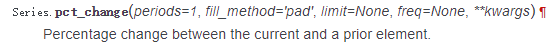
当前元素和上一个元素的变化百分比，第一个为nan

In [137]:
spx_corr = lambda x: x.corrwith(x['SPX']) #计算相关系数
rets = close_px.pct_change().dropna()
get_year = lambda x: x.year
print(rets[:5])
by_year = rets.groupby(get_year)
by_year.apply(spx_corr) #按年份计算每一列与列"SPX"的相关系数

                AAPL      MSFT       XOM       SPX
2003-01-03  0.006757  0.001421  0.000684 -0.000484
2003-01-06  0.000000  0.017975  0.024624  0.022474
2003-01-07 -0.002685  0.019052 -0.033712 -0.006545
2003-01-08 -0.020188 -0.028272 -0.004145 -0.014086
2003-01-09  0.008242  0.029094  0.021159  0.019386


,AAPL,MSFT,XOM,SPX
2003,0.541124,0.745174,0.661265,1.0
2004,0.374283,0.588531,0.557742,1.0
2005,0.467540,0.562374,0.631010,1.0
2006,0.428267,0.406126,0.518514,1.0
2007,0.508118,0.658770,0.786264,1.0
2008,0.681434,0.804626,0.828303,1.0
2009,0.707103,0.654902,0.797921,1.0
2010,0.710105,0.730118,0.839057,1.0
2011,0.691931,0.800996,0.859975,1.0


In [138]:
by_year.apply(lambda g: g['AAPL'].corr(g['MSFT']))

2003    0.480868
2004    0.259024
2005    0.300093
2006    0.161735
2007    0.417738
2008    0.611901
2009    0.432738
2010    0.571946
2011    0.581987
dtype: float64

### example:组级别的线性回归 

In [139]:
import statsmodels.api as sm
def regress(data, yvar, xvars):
    Y = data[yvar]
    X = data[xvars]
    X['intercept'] = 1.
    result = sm.OLS(Y, X).fit()#？？？？？？
    return result.params

In [140]:
by_year.apply(regress, 'AAPL', ['SPX'])

,SPX,intercept
2003,1.195406,0.000710
2004,1.363463,0.004201
2005,1.766415,0.003246
2006,1.645496,0.000080
2007,1.198761,0.003438
2008,0.968016,-0.001110
2009,0.879103,0.002954
2010,1.052608,0.001261
2011,0.806605,0.001514


## 10.4 透视表和交叉表 

In [141]:
tips.pivot_table(index=['day', 'smoker']) #aggfunc='mean'

size       tip   tip_pct  total_bill
day  smoker                                          
Fri  No      2.250000  2.812500  0.151650   18.420000
     Yes     2.066667  2.714000  0.174783   16.813333
Sat  No      2.555556  3.102889  0.158048   19.661778
     Yes     2.476190  2.875476  0.147906   21.276667
Sun  No      2.929825  3.167895  0.160113   20.506667
     Yes     2.578947  3.516842  0.187250   24.120000
Thur No      2.488889  2.673778  0.160298   17.113111
     Yes     2.352941  3.030000  0.163863   19.190588

In [142]:
tips.pivot_table(['tip_pct', 'size'], index=['time', 'day'],
                 columns='smoker')

size             tip_pct          
smoker             No       Yes        No       Yes
time   day                                         
Dinner Fri   2.000000  2.222222  0.139622  0.165347
       Sat   2.555556  2.476190  0.158048  0.147906
       Sun   2.929825  2.578947  0.160113  0.187250
       Thur  2.000000       NaN  0.159744       NaN
Lunch  Fri   3.000000  1.833333  0.187735  0.188937
       Thur  2.500000  2.352941  0.160311  0.163863

In [145]:
tips.pivot_table(values=['tip_pct', 'size'], index=['time', 'day'],
                 columns='smoker', margins=True) #margin是否汇总

size                       tip_pct                    
smoker             No       Yes       All        No       Yes       All
time   day                                                             
Dinner Fri   2.000000  2.222222  2.166667  0.139622  0.165347  0.158916
       Sat   2.555556  2.476190  2.517241  0.158048  0.147906  0.153152
       Sun   2.929825  2.578947  2.842105  0.160113  0.187250  0.166897
       Thur  2.000000       NaN  2.000000  0.159744       NaN  0.159744
Lunch  Fri   3.000000  1.833333  2.000000  0.187735  0.188937  0.188765
       Thur  2.500000  2.352941  2.459016  0.160311  0.163863  0.161301
All          2.668874  2.408602  2.569672  0.159328  0.163196  0.160803

In [146]:
tips.pivot_table('tip_pct', index=['time', 'smoker'], columns='day',
                 aggfunc=len, margins=True)

day             Fri   Sat   Sun  Thur    All
time   smoker                               
Dinner No       3.0  45.0  57.0   1.0  106.0
       Yes      9.0  42.0  19.0   NaN   70.0
Lunch  No       1.0   NaN   NaN  44.0   45.0
       Yes      6.0   NaN   NaN  17.0   23.0
All            19.0  87.0  76.0  62.0  244.0

In [147]:
tips.pivot_table('tip_pct', index=['time', 'size', 'smoker'],
                 columns='day', aggfunc='mean', fill_value=0)

day                      Fri       Sat       Sun      Thur
time   size smoker                                        
Dinner 1    No      0.000000  0.137931  0.000000  0.000000
            Yes     0.000000  0.325733  0.000000  0.000000
       2    No      0.139622  0.162705  0.168859  0.159744
            Yes     0.171297  0.148668  0.207893  0.000000
       3    No      0.000000  0.154661  0.152663  0.000000
            Yes     0.000000  0.144995  0.152660  0.000000
       4    No      0.000000  0.150096  0.148143  0.000000
            Yes     0.117750  0.124515  0.193370  0.000000
       5    No      0.000000  0.000000  0.206928  0.000000
            Yes     0.000000  0.106572  0.065660  0.000000
       6    No      0.000000  0.000000  0.103799  0.000000
Lunch  1    No      0.000000  0.000000  0.000000  0.181728
            Yes     0.223776  0.000000  0.000000  0.000000
       2    No      0.000000  0.000000  0.000000  0.166005
            Yes     0.181969  0.000000  0.000000  0.158843
       3    No      0.187735  0.000000  0.000000  0.084246
            Yes     0.000000  0.000000  0.000000  0.204952
       4    No      0.000000  0.000000  0.000000  0.138919
            Yes     0.000000  0.000000  0.000000  0.155410
       5    No      0.000000  0.000000  0.000000  0.121389
       6    No      0.000000  0.000000  0.000000  0.173706

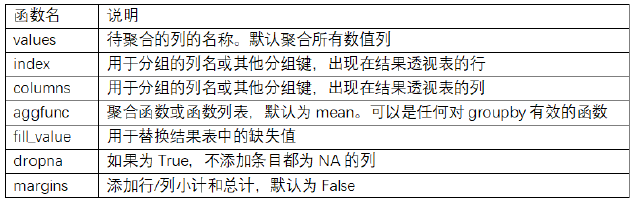

### 交叉表:crosstab 

In [150]:
from io import StringIO
data = """\
Sample  Nationality  Handedness
1   USA  Right-handed
2   Japan    Left-handed
3   USA  Right-handed
4   Japan    Right-handed
5   Japan    Left-handed
6   Japan    Right-handed
7   USA  Right-handed
8   USA  Left-handed
9   Japan    Right-handed
10  USA  Right-handed"""
data = pd.read_table(StringIO(data), sep='\s+')
data

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: read_table is deprecated, use read_csv instead.
  


,Sample,Nationality,Handedness
0,1,USA,Right-handed
1,2,Japan,Left-handed
2,3,USA,Right-handed
3,4,Japan,Right-handed
4,5,Japan,Left-handed
5,6,Japan,Right-handed
6,7,USA,Right-handed
7,8,USA,Left-handed
8,9,Japan,Right-handed
9,10,USA,Right-handed


In [151]:
pd.crosstab(data.Nationality, data.Handedness, margins=True)

Handedness,Left-handed,Right-handed,All
Nationality,,,
Japan,2,3,5
USA,1,4,5
All,3,7,10


In [152]:
pd.crosstab([tips.time, tips.day], tips.smoker, margins=True)

smoker        No  Yes  All
time   day                
Dinner Fri     3    9   12
       Sat    45   42   87
       Sun    57   19   76
       Thur    1    0    1
Lunch  Fri     1    6    7
       Thur   44   17   61
All          151   93  244